# Jupyter Lectures, First Year Project 2021

## Project 1 - Road collisions analysis, ITU Copenhagen

**Instructor: Michael Szell**

Course page: https://learnit.itu.dk/local/coursebase/view.php?ciid=590

This notebook contains all the code developed in the course lectures to wrangle and explore the data set from the project.

Contact: Michael Szell (misz@itu.dk)  
Created: 2021-01-29  
Last modified: 2021-01-29

<hr>

# Lecture 1: First data exploration

### Imports

In [112]:
import numpy as np
import matplotlib as plt
import csv
import pandas as pd
import seaborn as sns
from pathlib import Path

%run -i ../scripts/functions.py



Loaded functions.



### Constants

Constants are written all caps: https://www.python.org/dev/peps/pep-0008/#constants

In [113]:
PATH = {
    'raw': Path('../data/raw/'),
    'processed': Path('../data/processed/'),
    'interim': Path('../data/interim/'),
    'references': Path('../references')
}

PATH['accident'] = PATH['interim'] / "bradford_accidents.csv"
PATH['casual'] = PATH['interim'] / "bradford_casualties.csv"
PATH['vehicles'] = PATH['interim'] / "bradford_vehicles.csv"

PATH['var_lookup'] = PATH['references'] / 'variable lookup.xls'

In [114]:
# sheet_name=none gives all sheets 
VAR_LOOKUP = pd.read_excel(PATH['var_lookup'], sheet_name = None)

# No underscores in field name
VAR_LOOKUP['Day of Week']

,code,label
0,1,Sunday
1,2,Monday
2,3,Tuesday
3,4,Wednesday
4,5,Thursday
5,6,Friday
6,7,Saturday


### Load raw data

The data were downloaded from here on Jan 4th: https://data.gov.uk/dataset/road-accidents-safety-data  
That page was updated afterwards (Jan 8th), so local and online data may be inconsistent.

We first explore one data table, the accidents.

In [115]:
# Dict to store our data
DATA = {}

# Read data and explicitly define some data types for columns
DATA['accident'] = pd.read_csv(PATH['accident'], dtype={0: 'string', 31: 'string'}, encoding='utf-8-sig')

DATA['casual'] = pd.read_csv(PATH['casual'], dtype={0: 'string'}, encoding='utf-8-sig')

DATA['vehicles'] = pd.read_csv(PATH['vehicles'], dtype={0: 'string'}, encoding='utf-8-sig') # Maybe useful later: add index_col=0

In [116]:
HEADERS = {
    'accident': DATA['accident'].columns,
    'casual': DATA['casual'].columns,
    'vehicles': DATA['vehicles'].columns
}

HEADERS['accident']

Index(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

It is always good to start with a "sneak preview":

In [117]:
DATA['accident'][:5]

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
Accident_Index,,,,,,,,,,,,,,,,,,,,,
2019136111019,417000.0,433017.0,-1.743423,53.793206,13,3,2,1,01/01/2019,3,...,0,0,4,1,1,0,0,1,1,E01010606
2019136111467,419018.0,433809.0,-1.712742,53.800255,13,3,3,2,02/01/2019,4,...,0,0,1,1,1,0,0,1,1,E01010618
2019136121066,418157.0,430906.0,-1.725984,53.774194,13,3,2,1,02/01/2019,4,...,0,0,1,1,1,0,0,1,1,E01010615
2019136131015,415321.0,438238.0,-1.768652,53.840183,13,3,2,2,03/01/2019,5,...,0,5,1,1,1,0,0,1,1,E01010571
2019136131184,415008.0,431561.0,-1.773732,53.780180,13,3,1,1,03/01/2019,5,...,0,0,1,1,1,0,0,1,2,E01010735


Reminder and documentation on structured arrays:  
https://numpy.org/devdocs/user/basics.rec.html

#### Insight: Mixed variable types

Number of records

In [118]:
DATA['accident'].shape

(833, 31)

Number of fields

In [119]:
len(DATA['accident'].dtypes), len(DATA['vehicles'].dtypes), len(DATA['casual'].dtypes)
# +1 if you want to include the accident index field also

(31, 22, 15)

**"Data in the wild" puzzle: Why is the first field "\ufeffAccident_Index" and not "Accident_Index"?**

Fields

In [120]:
DATA['accident'].dtypes

Location_Easting_OSGR                          float64
Location_Northing_OSGR                         float64
Longitude                                      float64
Latitude                                       float64
Police_Force                                     int64
Accident_Severity                                int64
Number_of_Vehicles                               int64
Number_of_Casualties                             int64
Date                                            object
Day_of_Week                                      int64
Time                                            object
Local_Authority_(District)                       int64
Local_Authority_(Highway)                       object
1st_Road_Class                                   int64
1st_Road_Number                                  int64
Road_Type                                        int64
Speed_limit                                      int64
Junction_Detail                                  int64
Junction_C

Homework: Explore the other two tables the same way.

<hr>

In [121]:
DATA['vehicles'].dtypes

Vehicle_Reference                   int64
Vehicle_Type                        int64
Towing_and_Articulation             int64
Vehicle_Manoeuvre                   int64
Vehicle_Location-Restricted_Lane    int64
Junction_Location                   int64
Skidding_and_Overturning            int64
Hit_Object_in_Carriageway           int64
Vehicle_Leaving_Carriageway         int64
Hit_Object_off_Carriageway          int64
1st_Point_of_Impact                 int64
Was_Vehicle_Left_Hand_Drive?        int64
Journey_Purpose_of_Driver           int64
Sex_of_Driver                       int64
Age_of_Driver                       int64
Age_Band_of_Driver                  int64
Engine_Capacity_(CC)                int64
Propulsion_Code                     int64
Age_of_Vehicle                      int64
Driver_IMD_Decile                   int64
Driver_Home_Area_Type               int64
Vehicle_IMD_Decile                  int64
dtype: object

In [122]:
DATA['casual'].dtypes

Vehicle_Reference                     int64
Casualty_Reference                    int64
Casualty_Class                        int64
Sex_of_Casualty                       int64
Age_of_Casualty                       int64
Age_Band_of_Casualty                  int64
Casualty_Severity                     int64
Pedestrian_Location                   int64
Pedestrian_Movement                   int64
Car_Passenger                         int64
Bus_or_Coach_Passenger                int64
Pedestrian_Road_Maintenance_Worker    int64
Casualty_Type                         int64
Casualty_Home_Area_Type               int64
Casualty_IMD_Decile                   int64
dtype: object

# Lecture 2: Command line wrangling and dealing with missing data

A faster way of getting basic insights into a new data set than by using numpy is by using command line tools.

Let's get a first overview using `head`. There are 3 data tables: Accidents, Casualties, and Vehicles.

In [123]:
!head -n 5 "../data/interim/bradford_accidents.csv"

Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
2019136111019,417000.0,433017.0,-1.743423,53.793206,13,3,2,1,01/01/2019,3,08:00,200,E08000032,3,650,6,30,6,4,3,647,0,0,4,1,1,0,0,1,1,E01010606
2019136111467,419018.0,433809.0,-1.712742,53.800255,13,3,3,2,02/01/2019,4,13:20,200,E08000032,6,0,6,30,0,-1,-1,0,0,0,1,1,1,0,0,1,1,E01010618
2019136121066,418157.0,430906.0,-1.725984,53.774194,13,3,2,1,02/01/2019,4,15:45,200,E08000032,3,650,3,4

### General insights

#### Link between data tables

Records between data tables are linked through their `Accident_Index`.

Looking at the first Accident_Index 2019010128300, we can see there seems to be a one-to-many relation between accident->casualty and accident->vehicle, meaning there can be multiple casualties and vehicles involved in one accident (makes sense).

https://en.wikipedia.org/wiki/One-to-many_(data_model)

#### Dimensions

Number of records

https://en.wikipedia.org/wiki/Wc_(Unix)

In [124]:
!wc -l "../data/interim/bradford_accidents.csv"

834 ../data/interim/bradford_accidents.csv


Number of fields (in first line)

https://www.geeksforgeeks.org/awk-command-unixlinux-examples/

In [125]:
!head -n 1 "../data/interim/bradford_accidents.csv" | awk -F "," "{print NF}"

32


See and count all fields

https://en.wikipedia.org/wiki/Tr_(Unix)
https://en.wikipedia.org/wiki/Nl_(Unix)

In [126]:
!head -n 1 "../data/interim/bradford_accidents.csv" | tr "," "\n" | nl

     1	Accident_Index
     2	Location_Easting_OSGR
     3	Location_Northing_OSGR
     4	Longitude
     5	Latitude
     6	Police_Force
     7	Accident_Severity
     8	Number_of_Vehicles
     9	Number_of_Casualties
    10	Date
    11	Day_of_Week
    12	Time
    13	Local_Authority_(District)
    14	Local_Authority_(Highway)
    15	1st_Road_Class
    16	1st_Road_Number
    17	Road_Type
    18	Speed_limit
    19	Junction_Detail
    20	Junction_Control
    21	2nd_Road_Class
    22	2nd_Road_Number
    23	Pedestrian_Crossing-Human_Control
    24	Pedestrian_Crossing-Physical_Facilities
    25	Light_Conditions
    26	Weather_Conditions
    27	Road_Surface_Conditions
    28	Special_Conditions_at_Site
    29	Carriageway_Hazards
    30	Urban_or_Rural_Area
    31	Did_Police_Officer_Attend_Scene_of_Accident
    32	LSOA_of_Accident_Location


### Sanity checks

Has each record the same number of fields?

https://shapeshed.com/unix-uniq/  
https://www.putorius.net/uniq-command-linux.html

In [127]:
!awk -F "," "{print NF}" "../data/interim/bradford_accidents.csv" | sort | uniq -d

32


How many duplicate lines are there? (If more than 0, there could be a problem)

In [128]:
!sort "../data/interim/bradford_accidents.csv" | uniq -d | wc -l

0


More advanced stuff with `awk`: https://datafix.com.au/BASHing/2020-05-20.html

## Dealing with missing data

Using a masked array:  
https://numpy.org/devdocs/reference/maskedarray.baseclass.html#numpy.ma.MaskedArray

In [129]:
DATA['accident'][:5].isnull()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
Accident_Index,,,,,,,,,,,,,,,,,,,,,
2019136111019,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019136111467,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019136121066,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019136131015,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019136131184,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


How many values in total?  
Which fields are missing?

In [130]:
# DATA['accident'].isnull().sum(), "--- sum ---", DATA['accident'].isnull().sum().sum()

# Pandas: first sum the missing values row-wise, then sum all the row-wise sums to one single sum
# Missing                            Not missing
DATA['accident'].isna().sum().sum(), DATA['accident'].notna().sum().sum()

(3, 25820)

Summary of missing values:

In [131]:
# Overview of missing values in columns
DATA['accident'].isna().any()

# Get only the names of the columns with missing values
DATA['accident'].columns[DATA['accident'].isna().any()]

# Return the rows with missing values
DATA['accident'][DATA['accident'].isna().any(axis=1)]['Time']

Accident_Index
20191361B0976    NaN
20191363F1887    NaN
2019136CI1516    NaN
Name: Time, dtype: object

## Task 1 - Frequency of road collisions in your city for...

### a) ...different age groups

In [132]:
# Age analysis
DATA['casual']['Age_Band_of_Casualty'].value_counts()

6     176
7     170
4     161
8     149
5     141
9      85
3      75
10     49
2      42
1      37
11     32
Name: Age_Band_of_Casualty, dtype: int64

### b) ...in different times
(during the day, the week, or year)

In [133]:
# Time analysis
DATA['accident']['Day_of_Week'].value_counts()

5    139
4    135
6    129
3    122
2    111
7    109
1     88
Name: Day_of_Week, dtype: int64

### c) ...and for differences in one other condition.

In [134]:
# Movement analysis - Task 1, c
DATA['casual']['Pedestrian_Movement'].value_counts()

0    873
1     98
3     50
9     45
2     20
4     13
5      9
7      5
6      3
8      1
Name: Pedestrian_Movement, dtype: int64

<hr>

# Lecture 3: Visual data exploration, Connecting tables, Association test

## Visual exploratory data analysis ("Plot your data")

### Bar plots of categorical variables

In [91]:
HEADERS['accident']

Index(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

In [92]:
DATA['accident']['Day_of_Week'][:4]

Accident_Index
2019136111019    3
2019136111467    4
2019136121066    4
2019136131015    5
Name: Day_of_Week, dtype: int64

We were lucky because the categories 1,2,3 were "nice". But usually they aren't, so we need to explicitly map to integers:

Instead of copy-pasting code, let's write a function.

Typing the variable lookup manually is cumbersome. Can we read the excel directly?  
pandas can: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

### Histograms of numerical variables

### Categorical scatterplots

Scatterplots are good for relating two numerical variables. If we have one numerical versus one categorical variable, we can do a box plot. But could we also visualize all data points? Yes: https://seaborn.pydata.org/tutorial/categorical.html

## Connecting tables with np.isin()

**Question: How many babies and toddlers died on UK roads in June 2019?**

Numpy has the fucntion isin() to select for a list of indices: https://numpy.org/doc/stable/reference/generated/numpy.isin.html

**Question: Who killed them?**

Homework

## Association test between two categorical variables 
**(Pearson $\chi^2$ test of independence)**

Inspired by:  
https://peterstatistics.com/CrashCourse/3-TwoVarUnpair/NomNom/NomNom-2a-Test.html  
https://bit.ly/3kbwKEL

**Let us ask: Is there a statistically significant association between accident severity and speed limit?**  
We ask because speed limit is something that the city government can regulate.

### Hypothesis testing

We are now in the realm of [Statistical hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing). In general, we must first state and compare two hypotheses:

- $H_0$ (null hypothesis): There is no statistically significant relationship between accident severity and speed limit.
- $H_\alpha$ (alternative hypothesis): There is a statistically significant relationship between accident severity and speed limit.

We must then 1) state+check statistical assumptions, 2) choose an appropriate test and test statistic $T$, 3) derive the distribution for the test statistic, 4) select a significance level $\alpha$, usually 0.01 or 0.05, 5) calculate the observed test statistic $t_{\mathrm obs}$, 6) calculate the [p-value](https://en.wikipedia.org/wiki/P-value). 

If the p-value $< \alpha$, then the null hypothesis will be rejected.

### Pearson $\chi^2$ test of independence

To test association between two categorical variables, one uses the [Pearson chi-square test of independence](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test). If the significance of this test (p-value) is below a significance level (typically 0.05), the two variables have a significant association.

The Pearson chi-square test should only be used if most cells have an expected count above 5, and the minimum expected count is at least 1.

We crosstabulate using pandas:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html

The cross tabulation is also known as contingency table.

The idea is now to compare these observed values with expected values.  
The expected values can be calculated using:
\begin{equation*}
E_{i,j} = \frac{R_i \times C_j}{N}
\end{equation*}
The $E_{i,j}$ indicates the expected count in row i, column j. The $R_i$ is the row total of row i, and $C_j$ the column total of column j. The $N$ is the grand total.

That was the manual way of doing it. `chi2_contingency()` can do it for us automatically:

We now know that the association is significant, but how strong is it?  
Cramer's V, for example, can give an answer: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

The formula is:
\begin{equation*}
V=\sqrt{\frac{\chi^{2} / N}{\min (c-1, r-1)}}
\end{equation*}
where $c$ is the number of columns, $r$ is the number of rows.

Let us visualize this and make a human-readable plot and report below.

**Conclusion**

What about statistical tests for different combinations of numerical/categorical variables?
<img src="../references/flowchart-for-choosing-a-statistical-test.png" width="600px"/>

<hr>

## Excercise 03

- Check that all Number_of_Vehicles and Number_of_Casualties values in the accidents table are correct, by counting all the corresponding records in the vehicles and casualties tables.


In [93]:
for each accident_index in accidents_data
    store acc_vehi = Number_of_Vehicles involved in accident
    store acc_casult = Number_of_Casualties involved in accident
    store vechi_index_count and count how many times accident_index appear in vechicles
    store casual_index_count and count how many times accident_index appear in casualties

    if acc_vehi != vechi_index_count:
        store anomaly
    
    if acc_casult != casual_index_count:
        store anaomly

report summary

SyntaxError: invalid syntax (<ipython-input-93-9fb7a38753dd>, line 1)

- Try out categorical scatterplots to explore combinations of numerical and categorical variables (and possible a third categorical variable for hue), where this makes sense.

In [137]:
VAR_LOOKUP["Casualty Type"]

,code,label
0,0,Pedestrian
1,1,Cyclist
2,2,Motorcycle 50cc and under rider or passenger
3,3,Motorcycle 125cc and under rider or passenger
4,4,Motorcycle over 125cc and up to 500cc rider or...
5,5,Motorcycle over 500cc rider or passenger
6,8,Taxi/Private hire car occupant
7,9,Car occupant
8,10,Minibus (8 - 16 passenger seats) occupant
9,11,Bus or coach occupant (17 or more pass seats)


In [214]:
# Filter
casualty_type_pedestrian = DATA['casual']["Casualty_Type"] == 0
casualty_type_cyclist = DATA['casual']["Casualty_Type"] == 1
casualty_type_car = DATA['casual']["Casualty_Type"] == 9
no_unkown_age = DATA["casual"]["Age_of_Casualty"] > -1

mask = (casualty_type_pedestrian | casualty_type_cyclist | casualty_type_car) & (no_unkown_age)
mask[600:] = False # Restrict to at most 600 points. should be removed at some point!


,Casualty_Type,Age_of_Casualty
Accident_Index,,
2019136111019,9,56
2019136111467,9,50
2019136111467,9,46
2019136131015,9,52
2019136131015,9,38
...,...,...
20191367T0051,9,55
20191367T0051,9,27
20191367T0051,9,51


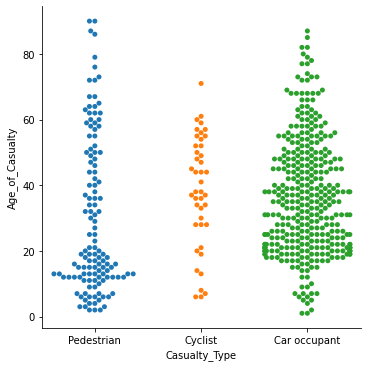

In [217]:
cat_data_1 = DATA["casual"]["Casualty_Type"][mask]
cat_data_2 = DATA["casual"]["Age_of_Casualty"][mask]

# Concaternate the data using columns (axis1)
con_cat_data = pd.concat([cat_data_1, cat_data_2], axis=1)

# Plot
fig = sns.catplot(x = 'Casualty_Type', y = 'Age_of_Casualty', data=con_cat_data, kind = "swarm") # also show: violin

fig.set_xticklabels(["Pedestrian", "Cyclist", "Car occupant"]);

con_cat_data


<hr>

# Lecture 4: Spatial filtering

## Filtering with external table

Let's select all rows for the city name:

We want to use this list of LSOA11 codes to restrict our accident data set.

Filter

Export

## Spatial filtering with shapely

Jupyter visualizes shapely objects!

Let's get all accident coordinates (from the whole UK)

`contains()` and `within()` check for point inclusion:

Limit vehicles and casualties to these AccidentIndices

What does it mean?  
See: https://www.computerhope.com/unix/udiff.htm

<hr>

# Lecture 5: Visualizing spatial data

Inspired by: https://alysivji.github.io/getting-started-with-folium.html

The heatmap is built with KDE:  
https://en.wikipedia.org/wiki/Kernel_density_estimation

We can also add automatic clusters: